In [8]:
import numpy as np
import pandas as pd
from sko.GA import GA_TSP
from utils import parse_UK_Data
import matplotlib.pyplot as plt
from scipy import spatial
dataset_path = "../datasets/UK150_20.txt"

meta_data, distance_data, station_data = parse_UK_Data(dataset_path)
print(len(station_data))

151


In [9]:
num_points = 50
points_coordinate = np.random.rand(num_points, 2)  # generate coordinate of points
distance_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')

#distance_matrix = distance_data.to_numpy()

def cal_total_distance(routine):
    '''The objective function. input routine, return total distance.
    cal_total_distance(np.arange(num_points))
    '''
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

In [10]:

ga_tsp = GA_TSP(func=cal_total_distance, n_dim=11, size_pop=50, max_iter=500, prob_mut=1)
best_points, best_distance = ga_tsp.run()

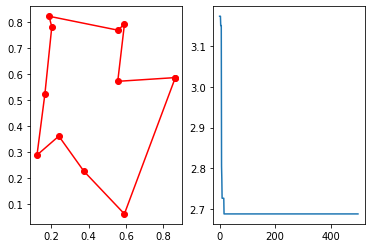

In [11]:
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_points, [best_points[0]]])
best_points_coordinate = points_coordinate[best_points_, :]
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[1].plot(ga_tsp.generation_best_Y)
plt.show()

In [43]:
from geopy.geocoders import Nominatim
address='{}'.format("Halmstad Återvinningscentral")
geolocator = Nominatim(user_agent="exjobbHalmstad")
location = geolocator.geocode(address)
print(location.address)
print((location.latitude, location.longitude))

Halmstad Återvinningscentral, Olofsdalsvägen, Kristineberg, Halmstad, Halmstads kommun, Hallands län, 302 41, Sverige
(56.6759572, 12.7972323)
